**References:**

---
The below code has been refered from multiple Kaggle HomeDepot competition solutions and from blogs. Below is the  list of the same.

1. Main Reference - Kaggle Solution -->  https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222
2. https://github.com/bhattbhavesh91/GA_Sessions/blob/master/ga_dsmp_5jan2019/16_feature_selection.ipynb
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
4. https://gilberttanner.com/blog/introduction-to-ensemble-learning
5. http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

# Data Loading and imports

**Imports and dependencies**

In [ ]:
!pip install -U gensim

In [ ]:
import pandas as pd
import sklearn as sk
import regex as re
import nltk
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from nltk import ngrams
from nltk.metrics.distance import edit_distance
from nltk.metrics.distance import jaccard_distance

In [ ]:
#https://stackoverflow.com/questions/48340341/how-to-read-csv-to-dataframe-in-google-colab
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
train_data_path = '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/train.csv'
prod_desc_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/product_descriptions.csv'
attr_path='/gdrive/MyDrive/ColabNotebooks/thesis/dataset/attributes.csv'
test_data_path= '/gdrive/MyDrive/ColabNotebooks/thesis/dataset/test.csv'

In [ ]:
df_train=pd.read_csv(train_data_path,encoding = "ISO-8859-1")
df_pd_desc=pd.read_csv(prod_desc_path)
df_attributes=pd.read_csv(attr_path)
df_test=pd.read_csv(test_data_path,encoding = "ISO-8859-1")

In [ ]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [ ]:
df_pd_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [ ]:
df_attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


# Exploratory Data Analysis - EDA

In [ ]:
print('Train set:  ')
print(df_train.isna().sum())
print(df_train.describe())
print('------------------------------------------------------------------')
print('Test set')
print(df_test.isna().sum())
print(df_test.describe())

Train set:  
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64
                  id    product_uid     relevance
count   74067.000000   74067.000000  74067.000000
mean   112385.709223  142331.911553      2.381634
std     64016.573650   30770.774864      0.533984
min         2.000000  100001.000000      1.000000
25%     57163.500000  115128.500000      2.000000
50%    113228.000000  137334.000000      2.330000
75%    168275.500000  166883.500000      3.000000
max    221473.000000  206650.000000      3.000000
------------------------------------------------------------------
Test set
id               0
product_uid      0
product_title    0
search_term      0
dtype: int64
                  id    product_uid
count  166693.000000  166693.000000
mean   123932.839741  149713.170445
std     71518.389174   37270.476881
min         1.000000  100001.000000
25%     61669.000000  116665.000000
50%    124004.000000  142445.000000
75%    18703

**Inference**:



---



Train data:
contains 74066 records,

1.   contains 74066 records,
2.   no empty records
3.   relevance has a mean value of 2.381634
3.   sample standard deviation of 0.533984 (with large sample size of 74066)
4.   this standard deviation is quite close to the population standard deviation

In [ ]:
print("# of unique search_terms (TRAIN) : ", len(df_train.search_term.unique()))
print("# of unique search_terms (TEST) : ", len(df_test.search_term.unique()))
print('------------------------------------------------------------------')
print("# of unique products (TRAIN) : ", len(df_train.product_uid.unique()))
print("# of unique products (TEST) : ", len(df_test.product_uid.unique()))
print('------------------------------------------------------------------')
print('# of rows with duplicate search_term and product_uid (TRAIN): ',df_train[['search_term', 'product_uid']].duplicated().sum())
print('# of rows with duplicate search_term and product_uid (TEST): ',df_test[['search_term', 'product_uid']].duplicated().sum())

# of unique search_terms (TRAIN) :  11795
# of unique search_terms (TEST) :  22427
------------------------------------------------------------------
# of unique products (TRAIN) :  54667
# of unique products (TEST) :  97460
------------------------------------------------------------------
# of rows with duplicate search_term and product_uid (TRAIN):  0
# of rows with duplicate search_term and product_uid (TEST):  13


In [ ]:
print(df_pd_desc.isna().sum())
print('------------------------------------------------------------------')
print("Total # of products :", len(df_pd_desc))
print("Total # of duplicate products :", df_pd_desc['product_uid'].duplicated().sum())

product_uid            0
product_description    0
dtype: int64
------------------------------------------------------------------
Total # of products : 124428
Total # of duplicate products : 0


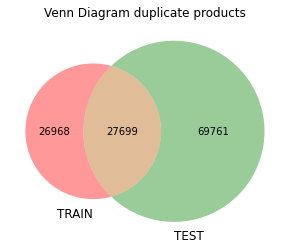

------------------------------------------------------------------


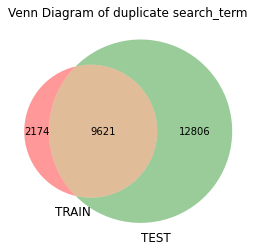

------------------------------------------------------------------


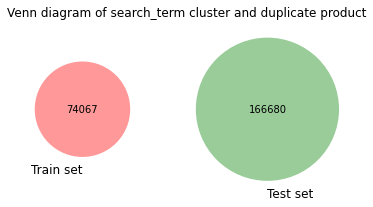

In [ ]:
#Duplicate products comparing Train and Test dataset
set1 = set(df_train.product_uid.to_list())
set2 = set(df_test.product_uid.to_list())
venn2([set1, set2], ('TRAIN', 'TEST'))
plt.title("Venn Diagram duplicate products")
plt.show()
print('------------------------------------------------------------------')
#Duplicate search_term comparing Train and Test dataset
set1 = set(df_train.search_term.to_list())
set2 = set(df_test.search_term.to_list())
venn2([set1, set2], ('TRAIN', 'TEST'))
plt.title("Venn Diagram of duplicate search_term")
plt.show()
print('------------------------------------------------------------------')
#Overlap between search_term and duplicate product cluster
set1 = set(df_train['search_term'].astype(str) + ' ' + df_train['product_uid'].astype(str))
set2 = set(df_test['search_term'].astype(str) + ' ' + df_test['product_uid'].astype(str))
venn2([set1, set2], ('Train set', 'Test set'))
plt.title("Venn diagram of search_term cluster and duplicate product")
plt.show()

**Inference:**


---





1.   There are 27699 duplicate products between train set and test set.
2.   Around 80% of the search_term are in train dataset are present in test dataset
3.   There are no overlaps between search_term and product clusters in both train and test dataset




Text(0.5, 0.98, 'Distribution of relevance scores')

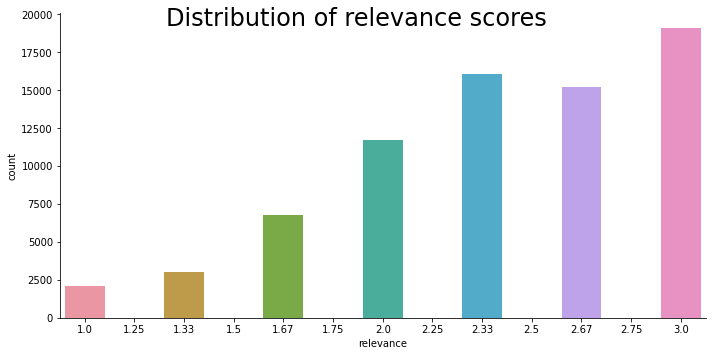

In [ ]:
plot=sns.catplot(x='relevance',kind='count',data=df_train,height=5,aspect=2)
#https://stackoverflow.com/questions/64258570/seaborn-title-error-attributeerror-facetgrid-object-has-no-attribute-set-t
plot.fig.suptitle("Distribution of relevance scores",
                  fontsize=24, fontdict={"weight": "bold"})


**Inference:**


---


TRAIN dataset has a distribution skewed towards high relevance i.e. from 2.33 to 3 compared to the relatively few lower score values from 1.0 to 2.0

100%|██████████| 166693/166693 [00:06<00:00, 25362.42it/s]


Text(0.5, 1.0, 'TEST Dataset')

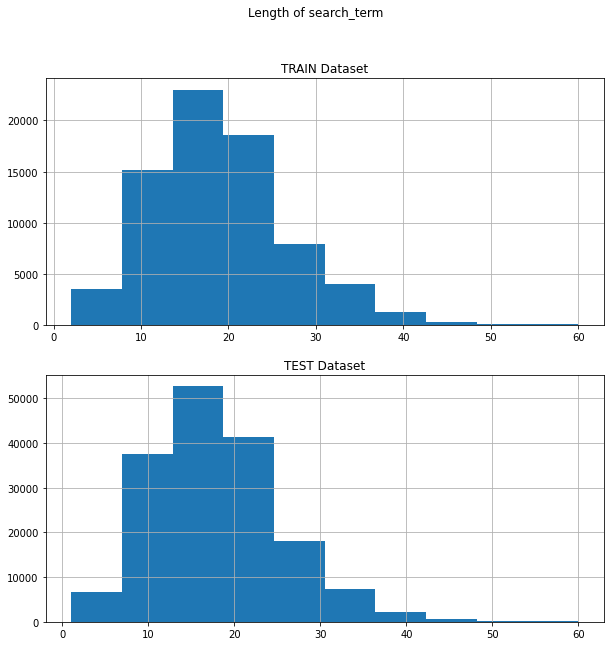

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Length of search_term')
search_term_len_tain = df_train.progress_apply(lambda x: len(x['search_term']), axis=1)
search_term_len_tain.hist(ax=axs[0])
search_term_len_test = df_test.progress_apply(lambda x: len(x['search_term']), axis=1)
search_term_len_test.hist(ax=axs[1])
axs[0].set_title('TRAIN Dataset')
axs[1].set_title('TEST Dataset')

**Inference:**


---


1.   search_term length is similar in both TRAIN and TEST dataset
2.   it is close to normal distribution with a mean of ~16


Text(0.5, 1.0, 'TEST Dataset')

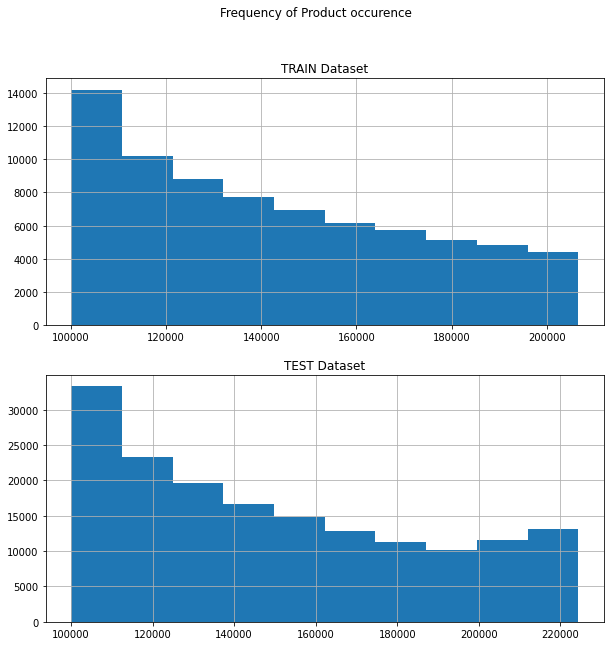

In [ ]:
fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Frequency of Product occurence')
df_train['product_uid'].hist(ax=axs[0])
df_test['product_uid'].hist(ax=axs[1])
axs[0].set_title('TRAIN Dataset')
axs[1].set_title('TEST Dataset')

**Inference:**


---


1.   frequency of occurrence of products is similar in both TRAIN and TEST dataset

In [ ]:
df_attributes.isna().sum()

product_uid     155
name            155
value          2284
dtype: int64

**Inference:**


---
1.  There are 155 rows with a null values in product_uid and name column and 2284 rows with a null value column in the product attribute. 
2.  It is obvious that some products don't have attributes
3.  Nevertheless if the attributes are not valid they should not be included in this table and left empty.

In [ ]:
# List of attributes having product_uid but no value
df_attributes[np.invert(df_attributes.isnull().product_uid) & df_attributes.isnull().value]

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
7898,100329.0,Fastener recommendation,NaN
...,...,...,...
2040533,224234.0,Hardware Finish Family,NaN
2040775,224246.0,Mosaic Sub Unit Length (in.),NaN
2040776,224246.0,Mosaic Sub Unit Width (in.),NaN
2041817,224289.0,Bore offset,NaN


In [ ]:
# List with out producrt_uid will have remaining fields empty
df_attributes[df_attributes.isnull().product_uid].isnull().sum()

product_uid    155
name           155
value          155
dtype: int64

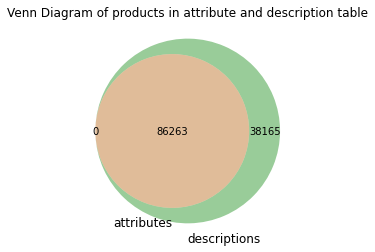

In [ ]:
set1 = set(df_attributes.product_uid.dropna().astype('int64'))
set2 = set(df_pd_desc.product_uid)
venn2([set1, set2], ('attributes', 'descriptions'))
plt.title("Venn Diagram of products in attribute and description table")
plt.show() 

**Inference:**


---
1.  Description contains all the products & its attributes in both the train and test dataset

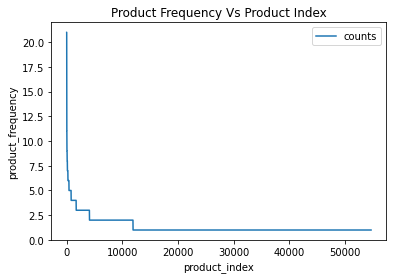

In [ ]:
#Product Frequency
#reference --> https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe
product_count_frequency = df_train['product_uid'].value_counts().rename_axis('unique_values').reset_index(name='counts')

#reference --> https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.line.html
product_count_frequency.plot.line(y='counts',title='Product Frequency Vs Product Index',xlabel='product_index',ylabel='product_frequency')

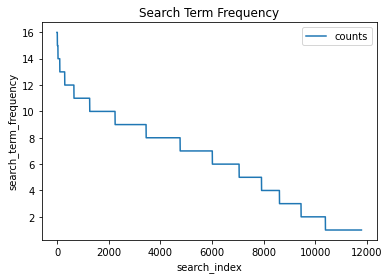

In [ ]:
#search_term frequency
search_question_frequency = df_train['search_term'].value_counts().rename_axis('unique_values').reset_index(name='counts')
search_question_frequency.plot.line(y='counts',title='Search Term Frequency',xlabel='search_index',ylabel='search_term_frequency')

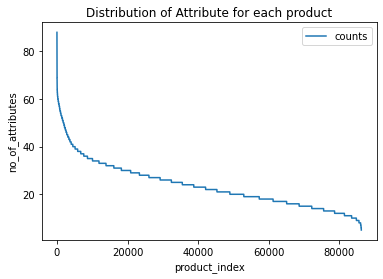

In [ ]:
#attribute frequency
attribute_frequency = df_attributes['product_uid'].value_counts().rename_axis('unique_values').reset_index(name='counts')
attribute_frequency.plot.line(y='counts',title='Distribution of Attribute for each product',xlabel='product_index',ylabel='no_of_attributes')

**Inference:**


---
1.  small number of attributes have a large number of products available
2.  remaining attributes have very few products with them.
3.  products with attributes will have a brand name

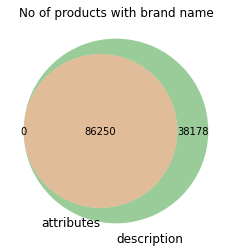

In [ ]:
set1 = set(df_attributes[df_attributes['name'] == 'MFG Brand Name'].product_uid.astype('int64'))
set2 = set(df_pd_desc.product_uid)
venn2([set1, set2], ('attributes', 'description'))
plt.title("No of products with brand name")
plt.show() 

**Inference:**


---
1. only 13 products that do not have a Brand Name
2. use of brand name is important, because relevance score is calculated based on matches with brand name


# Data Pre-Processing

**Drop null values**

In [ ]:
#dropping id column of train df
df_train = df_train.drop(['id'], axis=1)

# dropping null values from attribute df
df_attributes = df_attributes.dropna()

#attribute table: product_uid is in float64 and hece converting to int64 to be in sync with other df
df_attributes = df_attributes.astype({'product_uid': 'int64'})

# retrieve data on brands
brand_name_temp = df_attributes[df_attributes['name'] == 'MFG Brand Name']
brand_name_temp['brand'] = brand_name_temp['value']
brand_name_temp = brand_name_temp.drop(['name', 'value'], axis=1)
brand_name_temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,product_uid,brand
9,100001,Simpson Strong-Tie
37,100002,BEHR Premium Textured DeckOver
69,100003,STERLING
93,100004,Grape Solar
122,100005,Delta
...,...,...
2044702,224422,Everbilt
2044734,224423,Coastal Shower Doors
2044747,224424,stufurhome
2044774,224425,Home Decorators Collection


**Merging attribute columns to attribute create summary**

In [ ]:
%%time
df_attributes['attribute_summary'] = df_attributes.progress_apply(lambda x: (x['name'] + ' ' + x['value']) ,axis=1)
df_attributes = df_attributes.drop(labels=['name', 'value'], axis=1)
df_attributes = pd.pivot_table(df_attributes, index='product_uid', aggfunc= lambda x : " ".join(x))

100%|██████████| 2042519/2042519 [00:49<00:00, 41107.12it/s]


CPU times: user 46.8 s, sys: 819 ms, total: 47.6 s
Wall time: 51.3 s


In [ ]:
print(df_attributes.head())

                                             attribute_summary
product_uid                                                   
100001       Bullet01 Versatile connector for various 90° c...
100002       Application Method Brush,Roller,Spray Assemble...
100003       Built-in flange Yes Bullet01 Slightly narrower...
100004       Amperage (amps) 8.56 Bullet01 Positive power t...
100005       Bath Faucet Type Combo Tub and Shower Built-in...


**Inference**

---
1.  resultant dataframe contains product_uid with the corresponding merged attribute_summary


**Merge product description with train and test data frame**

In [ ]:
df_train = df_train.merge(df_pd_desc, on='product_uid', how='left')
df_test = df_test.merge(df_pd_desc, on='product_uid', how='left')


In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,product_description
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


**Merge attributes dataframe with train and test data frame**

In [ ]:
df_train = df_train.merge(df_attributes, on='product_uid', how='left')
df_test = df_test.merge(df_attributes, on='product_uid', how='left')

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,product_description,attribute_summary
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,"Application Method Brush,Roller,Spray Assemble..."
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,product_description,attribute_summary
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...


**Merge brand_name with train and test data frame**

In [ ]:
df_train = df_train.merge(brand_name_temp, on='product_uid', how='left')
df_test = df_test.merge(brand_name_temp, on='product_uid', how='left')

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,product_description,attribute_summary,brand
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,"Application Method Brush,Roller,Spray Assemble...",BEHR Premium Textured DeckOver
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...,Delta
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...,Delta


In [ ]:
df_test.head()

,id,product_uid,product_title,search_term,product_description,attribute_summary,brand
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie


In [ ]:
df_train['attribute_summary'] = df_train['attribute_summary'].fillna('NoAttribute')
df_train['brand'] = df_train['brand'].fillna('NoBrand')
df_train.isna().sum()

df_test['attribute_summary'] = df_test['attribute_summary'].fillna('NoAttribute')
df_test['brand'] = df_test['brand'].fillna('NoBrand')

**Inference:**

---


1.  There are 13 products do not have a brand name 
2.  38k products that do not have an attribute
3.  these empty values needs to be filled for later processing.

In [ ]:
df_train.head()

,product_uid,product_title,search_term,relevance,product_description,attribute_summary,brand
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,"Application Method Brush,Roller,Spray Assemble...",BEHR Premium Textured DeckOver
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...,Delta
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Bath Faucet Type Combo Tub and Shower Built-in...,Delta


In [ ]:
df_test

,id,product_uid,product_title,search_term,product_description,attribute_summary,brand
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Bullet01 Versatile connector for various 90° c...,Simpson Strong-Tie
...,...,...,...,...,...,...,...
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,Create a neat yet stylish storage space for or...,Assembly Required No Bullet01 Solid wood const...,stufurhome
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,Our Bullnose Adirondack Chair Cushions fit Adi...,Assembled Depth (in.) 49 in Assembled Height (...,Home Decorators Collection
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,Joist hangers are designed to provide support ...,NoAttribute,NoBrand
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,These socket cap screws are ideal for applicat...,NoAttribute,NoBrand


**Data Cleaning -- Remove special characters**

reference--> https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222

Removal of special characters (@, -, $,) in sentences

In [ ]:
print("Regex [^A-Za-z0-9]+ for --> 90Â° : " + re.sub('[^A-Za-z0-9]+', ' ', ' 90Â°'))
def remove_special_char(row):
    row['product_title'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_title'])
    row['search_term'] = re.sub('[^A-Za-z0-9]+', ' ', row['search_term'])
    row['product_description'] = re.sub('[^A-Za-z0-9]+', ' ', row['product_description'])
    row['attribute_summary'] = re.sub('[^A-Za-z0-9]+', ' ', row['attribute_summary'])

    row['product_title'] = row['product_title'].lower()
    row['search_term'] = row['search_term'].lower()
    row['product_description'] = row['product_description'].lower()
    row['attribute_summary'] = row['attribute_summary'].lower()
    return row
df_train = df_train.progress_apply(remove_special_char, axis=1)

df_test = df_test.progress_apply(remove_special_char, axis=1)



Regex [^A-Za-z0-9]+ for --> 90Â° :  90 


100%|██████████| 166693/166693 [01:27<00:00, 1915.12it/s]


**Data Cleaning -- Standardizing measurement units**

In [ ]:
def measurement_standardization(s):
    s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
    s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1 in. ", s)
    s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1 ft. ", s)
    s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1 lb. ", s)
    s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1 sq.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1 cu.ft. ", s)
    s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1 gal. ", s)
    s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1 oz. ", s)
    s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1 cm. ", s)
    s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1 mm. ", s)
    s = s.replace("°"," degrees ")
    s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1 deg. ", s)
    s = s.replace(" v "," volts ")
    s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1 volt. ", s)
    s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1 watt. ", s)
    s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1 amp. ", s)
    s = re.sub(' +', " ", s)
    return s
df_train['product_title'] = df_train.progress_apply(lambda x: measurement_standardization(x['product_title']), axis=1)
df_train['search_term'] = df_train.progress_apply(lambda x: measurement_standardization(x['search_term']), axis=1)
df_train['attribute_summary'] = df_train.progress_apply(lambda x: measurement_standardization(x['attribute_summary']), axis=1)
df_train['product_description'] = df_train.progress_apply(lambda x: measurement_standardization(x['product_description']), axis=1)

df_test['product_title'] = df_test.progress_apply(lambda x: measurement_standardization(x['product_title']), axis=1)
df_test['search_term'] = df_test.progress_apply(lambda x: measurement_standardization(x['search_term']), axis=1)
df_test['attribute_summary'] = df_test.progress_apply(lambda x: measurement_standardization(x['attribute_summary']), axis=1)
df_test['product_description'] = df_test.progress_apply(lambda x: measurement_standardization(x['product_description']), axis=1)

100%|██████████| 166693/166693 [00:47<00:00, 3504.26it/s]


**Save pre-processed train and test dataframes to .csv files(no need to run them again in future)**

In [ ]:
df_train.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/pre_processed/df_pre_processed_train.csv', encoding='utf-8')
df_test.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/pre_processed/df_pre_processed_test.csv', encoding='utf-8')

# Feature Engineering

In [ ]:
df_train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/pre_processed/df_pre_processed_train.csv', encoding='utf-8')
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/pre_processed/df_pre_processed_test.csv', encoding='utf-8')
df_test = df_test.drop(['Unnamed: 0'], axis=1)



In [ ]:
df_train

,product_uid,product_title,search_term,relevance,product_description,attribute_summary,brand
0,100001,simpson strong tie 12 gauge angle,angle bracket,3.00,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
1,100001,simpson strong tie 12 gauge angle,l bracket,2.50,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
2,100002,behr premium textured deckover 1 gal. sc 141 t...,deck over,3.00,behr premium textured deckover is an innovativ...,application method brush roller spray assemble...,BEHR Premium Textured DeckOver
3,100005,delta vero 1 handle shower only faucet trim ki...,rain shower head,2.33,update your bathroom with the delta vero singl...,bath faucet type combo tub and shower built in...,Delta
4,100005,delta vero 1 handle shower only faucet trim ki...,shower only faucet,2.67,update your bathroom with the delta vero singl...,bath faucet type combo tub and shower built in...,Delta
...,...,...,...,...,...,...,...
74062,206638,atlantic windowpane 576 cd or 192 dvd blu ray ...,tv riser glass,1.00,atlantic inc 94835722 uniquely designed for ma...,assembled depth in 9 5 in. assembled height in...,Atlantic
74063,206639,philips 40 watt. halogen r20 flood light bulb ...,r20 halogen light,3.00,philips energy advantage lamps use less energy...,actual color temperature k 2700 average life h...,Philips
74064,206641,schlage camelot in active aged bronze handlese...,schlage lock siena half dummy knob with,2.33,the schlage camelot in active aged bronze hand...,application type entry assembled depth in 2 9 ...,Schlage
74065,206648,plastec 11 in. x 24 in. rose garden wall decor...,zen garden decor,3.00,the rose garden is inspired by the popular ear...,bullet01 in. door and outdoor use bullet02 fin...,Plastec


In [ ]:
df_test

,id,product_uid,product_title,search_term,product_description,attribute_summary,brand
0,1,100001,simpson strong tie 12 gauge angle,90 deg. bracket,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
1,4,100001,simpson strong tie 12 gauge angle,metal l brackets,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
2,5,100001,simpson strong tie 12 gauge angle,simpson sku able,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
3,6,100001,simpson strong tie 12 gauge angle,simpson strong ties,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
4,7,100001,simpson strong tie 12 gauge angle,simpson strong tie hcc668,not only do angles make joints stronger they a...,bullet01 versatile connector for various 90 co...,Simpson Strong-Tie
...,...,...,...,...,...,...,...
166688,240756,224424,stufurhome norma 24 in. w x 16 in. d x 34 in. ...,24 whtie storage cabinet,create a neat yet stylish storage space for or...,assembly required no bullet01 solid wood const...,stufurhome
166689,240757,224425,home decorators collection 49 in. d alessandro...,adirondeck cusion,our bullnose adirondack chair cushions fit adi...,assembled depth in 49 in. assembled height in ...,Home Decorators Collection
166690,240758,224426,simpson strong tie hb 3 1 2 x 14 in. top flang...,hb,joist hangers are designed to provide support ...,noattribute,NoBrand
166691,240759,224427,1 4 in. 20 tpi x 1 1 2 in. stainless steel but...,hex sockets,these socket cap screws are ideal for applicat...,noattribute,NoBrand


**Length of search_term**

In [ ]:
df_train['search_term_length'] = df_train.progress_apply(lambda x: len(x['search_term']), axis=1)
df_test['search_term_length'] = df_test.progress_apply(lambda x: len(x['search_term']), axis=1)

100%|██████████| 166693/166693 [00:03<00:00, 48193.63it/s]



**Last Word in title**

Inference:

---



1.  It is common to search with attribute + product format. 
2.  The last keyword is usually the name of that product. 
3.  This keyword will have an influence on the relevance score of the product.


In [ ]:
df_train['last_word_in_title'] = df_train.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

df_test['last_word_in_title'] = df_test.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_title'].split(), axis=1)

100%|██████████| 166693/166693 [00:03<00:00, 48226.01it/s]


**Last word in description**

Inference:

---


1.  This is similar to "last_word_in_title" feature

In [ ]:
df_train['last_word_in_desc'] = df_train.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)
df_test['last_word_in_desc'] = df_test.progress_apply(lambda x: x['search_term'].split()[-1] in x['product_description'].split(), axis=1)

100%|██████████| 166693/166693 [00:05<00:00, 31055.63it/s]


**Have brand,attributes or not**

Inference:

---
1.  Check whether product has a brand or attribute 
2.  products without brand or attribute are not often used, have less interest and have low relevance.

In [ ]:
# Have brand or not
df_train['have_brand_or_not'] = df_train.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

df_test['have_brand_or_not'] = df_test.progress_apply(lambda x: x['brand'] != 'NoBrand', axis=1)

100%|██████████| 166693/166693 [00:02<00:00, 71577.08it/s]


In [ ]:
# Have attribute_summary or not
df_train['have_attr_or_not'] = df_train.progress_apply(lambda x: x['attribute_summary'] != 'noattribute', axis=1)

df_test['have_attr_or_not'] = df_test.progress_apply(lambda x: x['attribute_summary'] != 'noattribute', axis=1)

100%|██████████| 166693/166693 [00:02<00:00, 70660.96it/s]


**Number in attributes**


Inference:

---

1. Check the number matches in the search_term with the product attributes (eg 12in. bracket...)

In [ ]:
def count_number_in_search_attr(sentence1, sentence2):
    search_term_tokens = sentence1.split(' ')
    numbers_in_search_term = set([i for i in search_term_tokens if i.isdigit()])
    attr_tokens = sentence2.split(' ')
    numbers_attr = set([i for i in attr_tokens if i.isdigit()])
    return len(numbers_in_search_term & numbers_attr)

df_train['numbers_in_attr'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['attribute_summary']), axis=1)

df_test['numbers_in_attr'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['attribute_summary']), axis=1)

100%|██████████| 166693/166693 [00:08<00:00, 19776.78it/s]


**Numbers in title**

Inference:

---

1. This is similar to "count_number_in_search_attr" where we search for numbers in title



In [ ]:
df_train['numbers_in_title'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_title']), axis=1)

df_test['numbers_in_title'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_title']), axis=1)

100%|██████████| 166693/166693 [00:04<00:00, 39979.08it/s]


**Number in description**
Inference:

---

1. This is similar to "numbers_in_attr" and "numbers_in_title" where we search for numbers in title

In [ ]:
df_train['numbers_in_desc'] = df_train.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_description']), axis=1)

df_test['numbers_in_desc'] = df_test.progress_apply(lambda x: count_number_in_search_attr(x['search_term'], x['product_description']), axis=1)

100%|██████████| 166693/166693 [00:07<00:00, 22959.62it/s]


**Common word count in Search_term, title, desc, attr**

Inference:

---

1.To count common words between search_term and title, description, attributes

In [ ]:
def common_word_count_ngrams(sentence1, sentence2, ngram=1, edit_distance_thresshold=0):
    sentence1 = sentence1.split(' ')
    sentence2 = sentence2.split(' ')
    ngrams_1 = set(ngrams(sentence1, ngram))
    ngrams_2 = set(ngrams(sentence2, ngram))
    if edit_distance_thresshold == 0:
        return len(ngrams_1 & ngrams_2)
    else:
        count = 0
        for i in ngrams_1:
            for j in ngrams_2:
                if edit_distance(i, j) <= edit_distance_thresshold:
                    count+=1
        return count

In [ ]:
df_train['title_common_word_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
df_train['desc_common_word_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
df_train['attr_common_words_count'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], edit_distance_thresshold=1), axis=1)

df_test['title_common_word_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], edit_distance_thresshold=1), axis=1)
df_test['desc_common_word_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], edit_distance_thresshold=1), axis=1)
df_test['attr_common_words_count'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], edit_distance_thresshold=1), axis=1)

100%|██████████| 166693/166693 [03:24<00:00, 816.60it/s]


In [ ]:
%%time
df_train['title_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
df_train['desc_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
df_train['attr_common_word_count_bigram'] = df_train.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], ngram=2,edit_distance_thresshold=4), axis=1)

df_test['title_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_title'], ngram=2, edit_distance_thresshold=4), axis=1)
df_test['desc_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['product_description'], ngram=2,edit_distance_thresshold=4), axis=1)
df_test['attr_common_word_count_bigram'] = df_test.progress_apply(lambda x: common_word_count_ngrams(x['search_term'], x['attribute_summary'], ngram=2,edit_distance_thresshold=4), axis=1)

100%|██████████| 166693/166693 [06:30<00:00, 426.85it/s]

CPU times: user 20min 24s, sys: 9.29 s, total: 20min 33s
Wall time: 20min 47s


**Cosine similarity for BOW vectors**

Inference:

---


1.   The product cos(theta)=A.B/(||A||*||B||)

In [ ]:
def cosine_similarity_sent(sentence1, sentence2):
    A = set(sentence1.split())
    B = set(sentence2.split())
    numerator = len(A & B)
    denominator = math.sqrt(len(A)) * math.sqrt(len(B))
    
    if not denominator:
        return 0.0
    else:
        return numerator / denominator

df_train['cosine_search_term_Title'] = df_train.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
df_train['cosine_search_term_desc'] = df_train.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)

df_test['cosine_search_term_Title'] = df_test.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_title']), axis=1) 
df_test['cosine_search_term_desc'] = df_test.progress_apply(lambda row: cosine_similarity_sent(row['search_term'], row['product_description']), axis=1)

100%|██████████| 166693/166693 [00:07<00:00, 22119.85it/s]


**check - search_term contains brand or not**

Inference:

---

1.  Check for the number of times the brand name found in the search_term 2. 2. 2.  search_terms with the brand name will often have higher relevance

In [ ]:
%%time
def includes_brand(search_term, brand, edit_dis_thresshold = 1):
    search_term = search_term.split(' ')
    brand = brand.split(' ')
    count = 0
    for i in search_term:
        for j in brand:
            if edit_distance(i, j) < edit_dis_thresshold:
                count+=1
    return count
    
df_train['search_term_contains_brand'] = df_train.progress_apply(lambda x: includes_brand(x['search_term'], x['brand']), axis=1)

df_test['search_term_contains_brand'] = df_test.progress_apply(lambda x: includes_brand(x['search_term'], x['brand']), axis=1)

100%|██████████| 166693/166693 [00:37<00:00, 4503.19it/s]

CPU times: user 53.6 s, sys: 462 ms, total: 54 s
Wall time: 54.2 s


**Jaccard Coefficient and Edit Distance and search_term**

Inference:

---

1. Jaccard Coefficient = no.of words (unique)common in both sentences (intersection) / no.of unique words in both sentences (union)
2. Edit Distance = process 2 words and see the no.of required actions(adding, editing, deleting) 
3. smallest possible distance between 2 words in search_term and other fields affects relevance.

Mean distance between search_term and other fields calculated as :

1. split search_term into words
2. loop through the above words and find the word (in the description) that has the smallest distance from the word under consideration (in the search_term).
3. sum the minimum distance /length(search_term) (Note:search_term is not empty and will never be divided by zero)

In [ ]:
%%time
def minimum_jaccard_coefficient(sentence1, sentence2):
    sentence1 = sentence1.strip().split(' ')
    sentence2 = sentence2.strip().split(' ')
    minimum_distance = 99999
    for i in sentence1:
        for j in sentence2:
            minimum_distance = min(jaccard_distance(set(i), set(j)), minimum_distance)
    return minimum_distance
def minimum_edit_distance(sentence1, sentence2):
    sentence1 = sentence1.split(' ')
    sentence2 = sentence2.split(' ')
    minimum_distance = 99999
    for i in sentence1:
        for j in sentence2:
            minimum_distance = min(edit_distance(i, j), minimum_distance)
    return minimum_distance

df_train['min_jcc_brand_with_search_term'] = df_train.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['brand']), axis=1)
df_train['min_edit_brand_with_search_term'] = df_train.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['brand']), axis=1)

df_test['min_jcc_brand_with_search_term'] = df_test.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['brand']), axis=1)
df_test['min_edit_brand_with_search_term'] = df_test.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['brand']), axis=1)

100%|██████████| 166693/166693 [00:37<00:00, 4450.00it/s]

CPU times: user 1min 2s, sys: 572 ms, total: 1min 3s
Wall time: 1min 3s


**Jaccard Coef and Edit Distance Title and Search_term**

In [ ]:
%%time
df_train['min_jcc_title_with_search_term'] = df_train.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['product_title']), axis=1)
df_train['min_edit_title_with_search_term'] = df_train.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['product_title']), axis=1)

df_test['min_jcc_title_with_search_term'] = df_test.progress_apply(lambda x: minimum_jaccard_coefficient(x['search_term'], x['product_title']), axis=1)
df_test['min_edit_title_with_search_term'] = df_test.progress_apply(lambda x: minimum_edit_distance(x['search_term'], x['product_title']), axis=1)

100%|██████████| 166693/166693 [03:37<00:00, 765.03it/s]

CPU times: user 5min 48s, sys: 2.71 s, total: 5min 50s
Wall time: 5min 52s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_title(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['product_title'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_product_title_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_title, axis=1)

df_test['mean_jcc_product_title_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_title, axis=1)

100%|██████████| 166693/166693 [00:21<00:00, 7747.77it/s]

CPU times: user 31.3 s, sys: 300 ms, total: 31.6 s
Wall time: 31.7 s


In [ ]:
%%time
def sum_jcc(sentence1, sentence2):
    return jaccard_distance(set(sentence1.strip().split(' ')), set(sentence2.strip().split(' ')))
def sum_edit_distance(sentence1, sentence2):
    return edit_distance(sentence1, sentence2)
    
df_train['sum_jaccard_product_title_with_search_term'] = df_train.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_title']), axis=1)
df_train['sum_edit_product_title_with_search_term'] = df_train.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

df_test['sum_jaccard_product_title_with_search_term'] = df_test.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_title']), axis=1)
df_test['sum_edit_product_title_with_search_term'] = df_test.progress_apply(lambda x: sum_edit_distance(x['search_term'], x['product_title']), axis=1)

100%|██████████| 166693/166693 [04:00<00:00, 693.69it/s]

CPU times: user 5min 57s, sys: 2.84 s, total: 5min 59s
Wall time: 6min


**Jaccard Coef and Edit Distance Description and Search Term**

In [ ]:
%%time
df_train['sum_jcc_prod_desc_with_search_term'] = df_train.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_description']), axis=1)
df_test['sum_jcc_prod_desc_with_search_term'] = df_test.progress_apply(lambda x: sum_jcc(x['search_term'], x['product_description']), axis=1)

100%|██████████| 166693/166693 [00:08<00:00, 19112.29it/s]

CPU times: user 12.6 s, sys: 129 ms, total: 12.7 s
Wall time: 12.7 s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_desc(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['product_description'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_product_desc_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_desc, axis=1)

df_test['mean_jcc_product_desc_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_desc, axis=1)

100%|██████████| 166693/166693 [03:12<00:00, 866.44it/s] 

CPU times: user 4min 40s, sys: 2.32 s, total: 4min 43s
Wall time: 4min 45s


In [ ]:
%%time
def get_mean_jcc_searchterm_and_attr(row):
    search_term_word = row['search_term'].split(' ')
    desc_word = row['attribute_summary'].split(' ')
    mean = 0.0
    for i in search_term_word:
        if i == '':
            continue
        min_ = 99999
        for j in desc_word:
            if j == '':
                continue
            min_ = min(min_, jaccard_distance(set(i), set(j)))
        mean+=min_
    mean = mean/len(search_term_word)
    return mean

df_train['mean_jcc_attr_with_search_term'] = df_train.progress_apply(get_mean_jcc_searchterm_and_attr, axis=1)

df_test['mean_jcc_attr_with_search_term'] = df_test.progress_apply(get_mean_jcc_searchterm_and_attr, axis=1)

100%|██████████| 166693/166693 [03:02<00:00, 914.09it/s] 

CPU times: user 4min 20s, sys: 2.13 s, total: 4min 22s
Wall time: 4min 23s


**Word2Vec Feature Self Corpus**

In [ ]:
# %%time
# Create corpus from the dataset being used in competition
temp = df_train['product_description']
temp = np.concatenate((temp, df_test['product_description']), axis=0)
temp = np.unique(temp)
sentences = [i.split(' ') for i in temp]
temp = df_train['search_term']
temp = np.concatenate((temp, df_test['search_term']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
temp = df_train['product_title']
temp = np.concatenate((temp, df_test['product_title']), axis=0)
temp = np.unique(temp)
temp = [i.split(' ') for i in temp]
sentences.extend(temp)
len(sentences)

253818

In [ ]:
!pip install -U gensim

In [ ]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
class callback(CallbackAny2Vec):
    '''Callback fn is trigged to print loss after each epoch'''
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
    
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

model = Word2Vec(sentences=sentences, vector_size=100, window=5, workers=4, min_count=1, 
                 compute_loss=True, callbacks=[callback()], epochs=20)
model.save('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/w2v_model_homedepot_100_2.model')

Loss after epoch 0: 5588554.0
Loss after epoch 1: 3907879.0
Loss after epoch 2: 3419216.0
Loss after epoch 3: 3266732.0
Loss after epoch 4: 2872423.0
Loss after epoch 5: 2638544.0
Loss after epoch 6: 2710054.0
Loss after epoch 7: 2591580.0
Loss after epoch 8: 2649296.0
Loss after epoch 9: 2583304.0
Loss after epoch 10: 2213946.0
Loss after epoch 11: 1754412.0
Loss after epoch 12: 1711096.0
Loss after epoch 13: 1688944.0
Loss after epoch 14: 1636480.0
Loss after epoch 15: 1645268.0
Loss after epoch 16: 1604544.0
Loss after epoch 17: 1504328.0
Loss after epoch 18: 1468636.0
Loss after epoch 19: 1395048.0


In [ ]:
%%time
# Load Pretrained Word2Vec Model to test with random words
model = Word2Vec.load("/gdrive/MyDrive/ColabNotebooks/thesis/dataset/model/w2v_model_homedepot_100_2.model")
vector1 = model.wv['mobile']  # get numpy vector of a word
vector2 = model.wv['phone']
similarity = model.wv.most_similar('computer', topn=10)  # get other similar words
similarity

CPU times: user 3.76 s, sys: 349 ms, total: 4.11 s
Wall time: 4.39 s


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([vector1], [vector2]).max(axis=1).shape[0]

1

**Word2Vec Cosine Similarity**

Inference:

---

1. to find a max cosine similarity of a word in search_term and a word in title

In [ ]:
%%time
def get_w2v_search_term_max_sim_score_title(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    mean = 0.0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
df_train['max_cosine_sim_per_word_st_pt'] = df_train.progress_apply(get_w2v_search_term_max_sim_score_title, axis=1)

df_test['max_cosine_sim_per_word_st_pt'] = df_test.progress_apply(get_w2v_search_term_max_sim_score_title, axis=1)

100%|██████████| 166693/166693 [02:11<00:00, 1266.81it/s]

CPU times: user 3min 19s, sys: 6.11 s, total: 3min 25s
Wall time: 3min 34s


Inference:

---

1. to find a max cosine similarity of a word in search_term and a word in product description

In [ ]:
%%time
def get_w2v_search_term_max_sim_score_desc(row):
    title = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    # get list of vectors of the words from title if they are in the model
    title_vec =  [model.wv[title_].tolist() for title_ in title if title_ in model.wv]
    # get list of vectors of the words from search_term if they are in the model
    search_term_vec = [model.wv[search_term_].tolist() for search_term_ in search_term if search_term_ in model.wv]
    mean = 0.0
    if len(search_term_vec) == 0 or len(title_vec) == 0: return 0
    #calculate cosine similarity in matrix format
    score_matrix = cosine_similarity(search_term_vec, title_vec)
    # get the maximum similarity value of a word in search_term with a certain word in the title
    score_matrix = score_matrix.max(axis = 1)
    assert(score_matrix.shape[0] == len(search_term_vec)) 
    mean = score_matrix.sum()/len(search_term_vec)
    return mean
    
df_train['max_cosine_sim_per_word_st_pd'] = df_train.progress_apply(get_w2v_search_term_max_sim_score_desc, axis=1)

df_test['max_cosine_sim_per_word_st_pd'] = df_test.progress_apply(get_w2v_search_term_max_sim_score_desc, axis=1)

100%|██████████| 166693/166693 [10:51<00:00, 256.02it/s]

CPU times: user 15min 43s, sys: 9min 49s, total: 25min 33s
Wall time: 15min 19s


Inference:

---



Calculate n_similarity -- calculate cosine similarity of 2 sentences, by taking taking mean of all vectors in 2 sentences and calculate the cosine sim on those 2 mean vectors)

In [ ]:
%%time
def w2v_sim_st_pt(row):
    title = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    title = [i for i in title if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(title) or not len(search_term): return 0
    return model.wv.n_similarity(title, search_term)

df_train['w2v_n_similarity_st_pt'] = df_train.progress_apply(w2v_sim_st_pt, axis=1)

df_test['w2v_n_similarity_st_pt'] = df_test.progress_apply(w2v_sim_st_pt, axis=1)

100%|██████████| 166693/166693 [00:30<00:00, 5464.67it/s]

CPU times: user 43.8 s, sys: 677 ms, total: 44.4 s
Wall time: 44.2 s


In [ ]:
%%time
def w2v_n_sim_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [i for i in description if i in model.wv]
    search_term = [i for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    return model.wv.n_similarity(description, search_term)

df_train[''] = df_train.progress_apply(w2v_n_sim_st_pd, axis=1)

df_test[''] = df_test.progress_apply(w2v_n_sim_st_pd, axis=1)

100%|██████████| 166693/166693 [02:22<00:00, 1171.46it/s]

CPU times: user 2min 53s, sys: 1.72 s, total: 2min 55s
Wall time: 3min 9s


Inference:

---


Word2Vec centroid RMSE -- this feature does not bring too much value, calculated by taking the mean of the word vectors in the sentence and then calculating the RMSE based on the 2 mean vectors of those two sentences)

In [ ]:
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pd(row):
    description = row['product_description'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

df_train['w2v_centroid_rmse_st_pd'] = df_train.progress_apply(w2v_centroid_rmse_st_pd, axis=1)

df_test['w2v_centroid_rmse_st_pd'] = df_test.progress_apply(w2v_centroid_rmse_st_pd, axis=1)

100%|██████████| 166693/166693 [03:07<00:00, 890.93it/s] 


In [ ]:
from sklearn.metrics import mean_squared_error
def w2v_centroid_rmse_st_pt(row):
    description = row['product_title'].strip().split(' ')
    search_term = row['search_term'].strip().split(' ')
    description = [model.wv[i] for i in description if i in model.wv]
    search_term = [model.wv[i] for i in search_term if i in model.wv]
    if not len(description) or not len(search_term): return 0
    mean_des = np.mean(description, axis=0)
    mean_ser = np.mean(search_term, axis=0)
    return mean_squared_error(mean_ser, mean_des)

df_train['w2v_centroid_rmse_st_pt'] = df_train.progress_apply(w2v_centroid_rmse_st_pt, axis=1)

df_test['w2v_centroid_rmse_st_pt'] = df_test.progress_apply(w2v_centroid_rmse_st_pt, axis=1)

100%|██████████| 166693/166693 [01:25<00:00, 1946.13it/s]


In [ ]:
df_train.corr()

,product_uid,relevance,search_term_length,last_word_in_title,last_word_in_desc,have_brand_or_not,have_attr_or_not,numbers_in_attr,numbers_in_title,numbers_in_desc,title_common_word_count,desc_common_word_count,attr_common_words_count,title_common_word_count_bigram,desc_common_word_count_bigram,attr_common_word_count_bigram,cosine_search_term_Title,cosine_search_term_desc,search_term_contains_brand,min_jcc_brand_with_search_term,min_edit_brand_with_search_term,min_jcc_title_with_search_term,min_edit_title_with_search_term,mean_jcc_product_title_with_search_term,sum_jaccard_product_title_with_search_term,sum_edit_product_title_with_search_term,sum_jcc_prod_desc_with_search_term,mean_jcc_product_desc_with_search_term,mean_jcc_attr_with_search_term,max_cosine_sim_per_word_st_pt,max_cosine_sim_per_word_st_pd,w2v_n_similarity_st_pt,w2v_n_similarity_st_pd,w2v_centroid_rmse_st_pd,w2v_centroid_rmse_st_pt
product_uid,1.000000,-0.130656,0.205922,0.012739,-0.052066,0.083980,0.082812,0.058453,0.038576,0.024320,0.177625,0.077812,0.082695,0.175901,0.085567,0.085227,0.103263,0.030773,0.018524,-0.073363,-0.089970,-0.138849,-0.138501,-0.046276,-0.114434,0.027011,-0.087041,0.078775,-0.041806,0.010301,-0.092300,0.065126,0.017002,-0.217085,-0.222736
relevance,-0.130656,1.000000,-0.048967,0.184479,0.176730,-0.145760,-0.145882,-0.017396,0.006484,0.002487,-0.064818,-0.015508,-0.070261,-0.067573,-0.025363,-0.057136,0.254675,0.183700,-0.010450,-0.029613,-0.014189,-0.181829,-0.158685,-0.354776,-0.217064,-0.043243,-0.107185,-0.266955,0.015243,0.329186,0.279541,0.195940,0.143124,0.133415,-0.011017
search_term_length,0.205922,-0.048967,1.000000,-0.061741,-0.035669,0.201287,0.202834,0.078540,0.047659,0.059401,0.646239,0.568579,0.516730,0.655059,0.593606,0.542168,0.200554,0.233198,-0.000833,-0.230180,-0.181635,-0.208188,-0.193478,0.094614,-0.293096,-0.025854,-0.338435,0.007374,-0.201379,-0.027247,0.025068,0.334273,0.379981,-0.338132,-0.378624
last_word_in_title,0.012739,0.184479,-0.061741,1.000000,0.617273,-0.144676,-0.145689,0.083018,0.121749,0.098029,0.056049,0.031902,-0.030016,0.052699,0.031356,-0.005856,0.559631,0.294027,-0.005257,0.010635,-0.026278,-0.320936,-0.319208,-0.481327,-0.457935,0.047026,-0.204910,-0.220707,0.039029,0.564535,0.328213,0.329454,0.156568,0.114519,-0.142614
last_word_in_desc,-0.052066,0.176730,-0.035669,0.617273,1.000000,-0.084293,-0.085264,0.059443,0.061737,0.103187,0.030813,0.068975,0.005630,0.028838,0.067542,0.021883,0.327105,0.516225,-0.005425,0.013990,-0.015800,-0.193995,-0.198544,-0.287012,-0.270300,0.013670,-0.355324,-0.455986,-0.033337,0.364875,0.561900,0.246087,0.256359,0.128594,-0.026326
have_brand_or_not,0.083980,-0.145760,0.201287,-0.144676,-0.084293,1.000000,0.995980,0.175056,-0.024336,-0.011966,0.135375,0.134281,0.594379,0.131963,0.131768,0.478242,-0.139544,-0.041002,0.014264,-0.156256,-0.203950,0.061303,0.059238,0.221810,0.090804,0.013350,-0.001310,0.075425,-0.869293,-0.226663,-0.100419,-0.016115,0.064609,-0.121756,-0.038869
have_attr_or_not,0.082812,-0.145882,0.202834,-0.145689,-0.085264,0.995980,1.000000,0.175222,-0.025078,-0.012696,0.134254,0.133852,0.596284,0.131018,0.131475,0.479991,-0.139654,-0.041215,0.014206,-0.155310,-0.202804,0.060922,0.059097,0.222050,0.090266,0.010882,-0.001304,0.075359,-0.872986,-0.227401,-0.100696,-0.015488,0.065990,-0.122146,-0.039156
numbers_in_attr,0.058453,-0.017396,0.078540,0.083018,0.059443,0.175056,0.175222,1.000000,0.721779,0.657379,0.316096,0.213761,0.285944,0.352569,0.237464,0.309515,0.235044,0.179371,-0.004131,0.037482,-0.026009,-0.090425,-0.095776,-0.083486,-0.267760,0.019249,-0.231918,0.042453,-0.231978,0.163508,0.115146,0.324088,0.129703,-0.039570,-0.258599
numbers_in_title,0.038576,0.006484,0.047659,0.121749,0.061737,-0.024336,-0.025078,0.721779,1.000000,0.795261,0.347654,0.199040,0.112568,0.392167,0.226082,0.145821,0.329569,0.204745,-0.005970,0.074094,0.022398,-0.118935,-0.118295,-0.179363,-0.359872,0.028323,-0.269766,0.064125,0.022897,0.221387,0.119711,0.388712,0.127480

**TF-IDF Feature**

Inference:

---

1.  data used to fit TFIDF Vectorizer are title + description of the products  with duplicates removed.
2. Vectorizer is configured to take 10000 words (max_features) in the order from highest to lowest TF value of the word.
3. Since the number of dimension is 10000 which is too large, it is required to reduce the dimension by retaining the key information. 
4. we can use SVD or PCA, but here TruncatedSVD of sklearn has been used to reduce the dimension from 10000 to 500.

In [ ]:
#reference --> https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=136
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

title_description_train = df_train["product_title"].astype(str) + '. ' + df_train["product_description"].astype(str)
title_description_test = df_test["product_title"].astype(str) + '. ' + df_test["product_description"].astype(str)
title_description_all =  title_description_train.append(title_description_test)
title_desc_unique = title_description_all.unique()
vectorizer = TfidfVectorizer(smooth_idf=True, min_df=2, max_features=10000, stop_words='english')

vectorizer.fit(title_desc_unique)

X_title_description_all = vectorizer.transform(title_description_all)

X_title_description_train = vectorizer.transform(title_description_train)
 #check the shape of the document-term matrix
print(X_title_description_train.shape)

X_title_description_test = vectorizer.transform(title_description_test)

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=500, algorithm='randomized', n_iter=10, random_state=122)
svd_model.fit(X_title_description_all)

truncated_title_description_train = svd_model.transform(X_title_description_train)

truncated_title_description_test = svd_model.transform(X_title_description_test)

print(truncated_title_description_train.shape)
tsvd_var_ratios = svd_model.explained_variance_ratio_
print('variance:', tsvd_var_ratios.sum())

X_search = vectorizer.transform(df_train['search_term'])
# shape of the document-term matrix
print(X_search.shape)

transformed_search_train = svd_model.transform(X_search)

X_search = vectorizer.transform(df_test['search_term'])
 # shape of the document-term matrix
print(X_search.shape)

transformed_search_test = svd_model.transform(X_search)

(74067, 10000)
(74067, 500)
variance explained 0.4678811175687141
(74067, 10000)
(166693, 10000)


**TFIDF Cosine Similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# Calculating cosine similarity of each pair of search_term and (title+description) at (sentence level) after truncated
cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_title_description_train)]
df_train['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

cosine_similarity_tfidf_search_title_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_title_description_test)]
df_test['cosine_similarity_tfidf_search_title_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_title_des]

In [ ]:
truncated_pt_train = svd_model.transform(vectorizer.transform(df_train["product_title"].astype(str)))
truncated_pt_test = svd_model.transform(vectorizer.transform(df_test["product_title"].astype(str)))

cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pt_train)]
df_train['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]
cosine_similarity_tfidf_search_title = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pt_test)]
df_test['cosine_similarity_tfidf_search_title'] = [i[0][0] for i in cosine_similarity_tfidf_search_title]

truncated_pd_train = svd_model.transform(vectorizer.transform(df_train["product_description"].astype(str)))
truncated_pd_test = svd_model.transform(vectorizer.transform(df_test["product_description"].astype(str)))

# Calculate the cosine similarity of each pair of search_term and description (sentence level) after truncated 
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_train, truncated_pd_train)]
df_train['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]
cosine_similarity_tfidf_search_des = [cosine_similarity([x], [y]) for x,y in zip(transformed_search_test, truncated_pd_test)]
df_test['cosine_similarity_tfidf_search_des'] = [i[0][0] for i in cosine_similarity_tfidf_search_des]

**BM25 Ranking**

In [ ]:
#reference:
#1. https://towardsdatascience.com/modeling-product-search-relevance-in-e-commerce-home-depot-case-study-8ccb56fbc5ab
#2.https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=144

def okapi_bm25_fit(corpus):
    tfidf_model = TfidfVectorizer(smooth_idf=False, token_pattern=r"(?u)\b\w+\b")
    tfidf_model.fit(corpus)
    idf_dict = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    avgdl = np.mean([len(doc.split()) for doc in corpus])
    params = {'idf_dict': idf_dict, 
            'avgdl' : avgdl,
            'N' : len(corpus)}
    return params

def okapi_bm25_score(query, doc, params, k=1.2, b=0.75):

    idf_dict = params['idf_dict']
    avgdl = params['avgdl']
    N = params['N']
    score_query = 0

    for word in query.split():
        dl = len(doc.split())
        tf = doc.count(word)
        if word in idf_dict.keys():
            idf = idf_dict[word]
        else: 
            idf = np.log(N+1) 

        score_word = idf*(tf*(k+1))/(tf + k*(1-b) + b*dl/avgdl)
        score_query += score_word

    return score_query

params_bm25_title = okapi_bm25_fit(df_train['product_title'])
df_train['bm25_ST'] = df_train.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)
df_train['bm25_ST'] = df_train.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)

# params_bm25_title = okapi_bm25_fit(df_test['product_title'])
df_test['bm25_ST'] = df_test.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)
df_test['bm25_ST'] = df_test.progress_apply(lambda row: okapi_bm25_score(row['search_term'], row['product_title'], params_bm25_title), axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 166693/166693 [00:05<00:00, 27894.50it/s]


**Min,Max TF, IDF**

Inference:

---

1. loop through the words in the search term to calculate the TF, IDF, TFIDF min, max and sum of the values as mentioned in the product title.

In [ ]:
#reference: https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=147


# For Train dataset

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in df_train.iterrows():
  search = row['search_term']
  text = row['product_title']
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in idf_dict.keys():
      tf = text.count(word)
      idf = idf_dict[word]
    else:
      tf = text.count(word)
      idf = np.log(N+1)

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))

df_train['max_tf_ST'] = max_tf
df_train['max_idf_ST'] = max_idf
df_train['max_tfidf_ST'] = max_tfidf

df_train['min_tf_ST'] = min_tf
df_train['min_idf_ST'] = min_idf
df_train['min_tfidf_ST'] = min_tfidf

df_train['sum_tf_ST'] = sum_tf
df_train['sum_idf_ST'] = sum_idf
df_train['sum_tfidf_ST'] = sum_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#reference: https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=147


# For Test dataset

idf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
N = len(title_desc_unique)
params = {'idf_dict':idf_dict, 'N':N}

max_tf = []
max_idf = []
max_tfidf = []

min_tf = []
min_idf = []
min_tfidf = []

sum_tf = []
sum_idf = []
sum_tfidf = []


for ind, row in df_test.iterrows():
  search = row['search_term']
  text = row['product_title']
  tf_vals = []
  idf_vals = []
  tfidf_vals = []
  for word in search.split():
    if word in idf_dict.keys():
      tf = text.count(word)
      idf = idf_dict[word]
    else:
      tf = text.count(word)
      idf = np.log(N+1)

    tf_vals.append(tf)
    idf_vals.append(idf)
    tfidf_vals.append(tf*idf)
  
  max_tf.append(max(tf_vals))
  min_tf.append(min(tf_vals))
  sum_tf.append(sum(tf_vals))

  max_idf.append(max(idf_vals))
  min_idf.append(min(idf_vals))
  sum_idf.append(sum(idf_vals))

  max_tfidf.append(max(tfidf_vals))
  min_tfidf.append(min(tfidf_vals))
  sum_tfidf.append(sum(tfidf_vals))

df_test['max_tf_ST'] = max_tf
df_test['max_idf_ST'] = max_idf
df_test['max_tfidf_ST'] = max_tfidf

df_test['min_tf_ST'] = min_tf
df_test['min_idf_ST'] = min_idf
df_test['min_tfidf_ST'] = min_tfidf

df_test['sum_tf_ST'] = sum_tf
df_test['sum_idf_ST'] = sum_idf
df_test['sum_tfidf_ST'] = sum_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


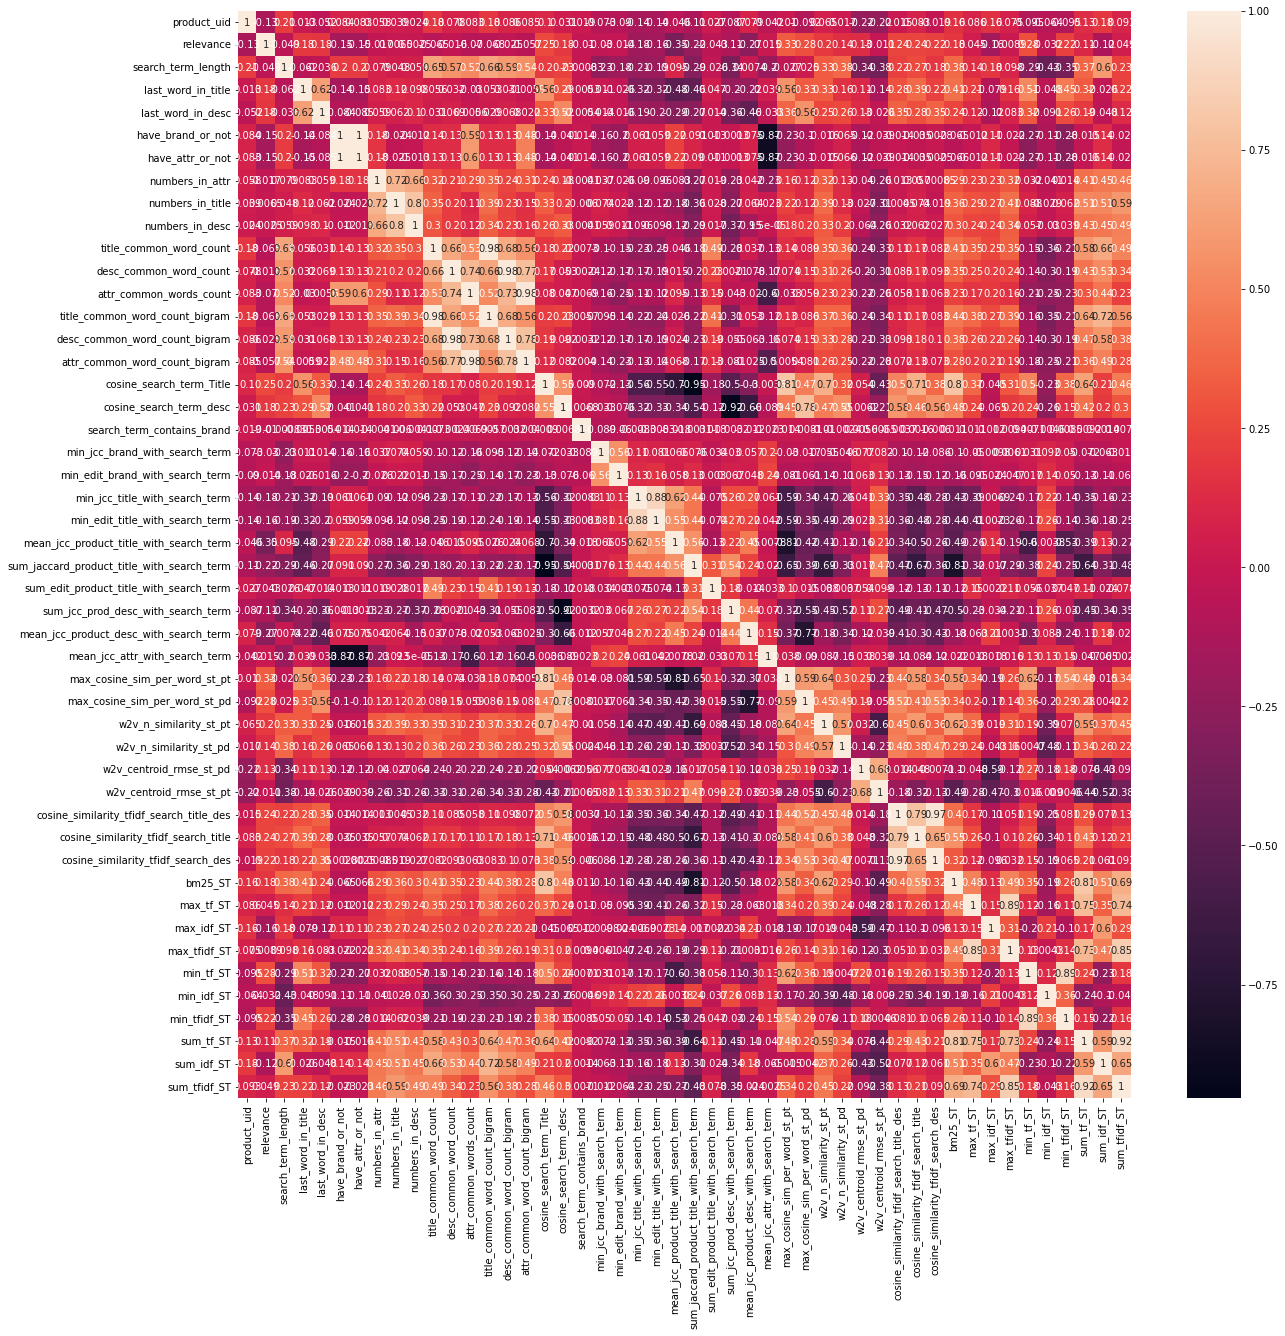

In [ ]:
#reference -- https://stackoverflow.com/questions/50259125/make-python-seaborn-heatmap-bigger
correlation_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_matrix, annot = True,ax=ax)
plt.show()
#interpretation of heatmpa-- https://stats.stackexchange.com/questions/392517/how-can-one-interpret-a-heat-map-plot

In [ ]:
df_train.corr()

,product_uid,relevance,search_term_length,last_word_in_title,last_word_in_desc,have_brand_or_not,have_attr_or_not,numbers_in_attr,numbers_in_title,numbers_in_desc,title_common_word_count,desc_common_word_count,attr_common_words_count,title_common_word_count_bigram,desc_common_word_count_bigram,attr_common_word_count_bigram,cosine_search_term_Title,cosine_search_term_desc,search_term_contains_brand,min_jcc_brand_with_search_term,min_edit_brand_with_search_term,min_jcc_title_with_search_term,min_edit_title_with_search_term,mean_jcc_product_title_with_search_term,sum_jaccard_product_title_with_search_term,sum_edit_product_title_with_search_term,sum_jcc_prod_desc_with_search_term,mean_jcc_product_desc_with_search_term,mean_jcc_attr_with_search_term,max_cosine_sim_per_word_st_pt,max_cosine_sim_per_word_st_pd,w2v_n_similarity_st_pt,w2v_n_similarity_st_pd,w2v_centroid_rmse_st_pd,w2v_centroid_rmse_st_pt,cosine_similarity_tfidf_search_title_des,cosine_similarity_tfidf_search_title,cosine_similarity_tfidf_search_des,bm25_ST,max_tf_ST,max_idf_ST,max_tfidf_ST,min_tf_ST,min_idf_ST,min_tfidf_ST,sum_tf_ST,sum_idf_ST,sum_tfidf_ST
product_uid,1.000000,-0.130656,0.205922,0.012739,-0.052066,0.083980,0.082812,0.058453,0.038576,0.024320,0.177625,0.077812,0.082695,0.175901,0.085567,0.085227,0.103263,0.030773,0.018524,-0.073363,-0.089970,-0.138849,-0.138501,-0.046276,-0.114434,0.027011,-0.087041,0.078775,-0.041806,0.010301,-0.092300,0.065126,0.017002,-0.217085,-0.222736,0.014900,0.082580,-0.019491,0.158602,0.086078,0.159249,0.075343,-0.095219,-0.064022,-0.095403,0.133450,0.183864,0.093104
relevance,-0.130656,1.000000,-0.048967,0.184479,0.176730,-0.145760,-0.145882,-0.017396,0.006484,0.002487,-0.064818,-0.015508,-0.070261,-0.067573,-0.025363,-0.057136,0.254675,0.183700,-0.010450,-0.029613,-0.014189,-0.181829,-0.158685,-0.354776,-0.217064,-0.043243,-0.107185,-0.266955,0.015243,0.329186,0.279541,0.195940,0.143124,0.133415,-0.011017,0.243493,0.244168,0.218889,0.175729,0.044949,-0.157063,0.008909,0.278594,-0.031675,0.221390,0.108182,-0.121642,0.049208
search_term_length,0.205922,-0.048967,1.000000,-0.061741,-0.035669,0.201287,0.202834,0.078540,0.047659,0.059401,0.646239,0.568579,0.516730,0.655059,0.593606,0.542168,0.200554,0.233198,-0.000833,-0.230180,-0.181635,-0.208188,-0.193478,0.094614,-0.293096,-0.025854,-0.338435,0.007374,-0.201379,-0.027247,0.025068,0.334273,0.379981,-0.338132,-0.378624,0.216619,0.266489,0.179917,0.384303,0.144239,0.181345,0.097866,-0.293418,-0.433119,-0.351725,0.372119,0.599280,0.231995
last_word_in_title,0.012739,0.184479,-0.061741,1.000000,0.617273,-0.144676,-0.145689,0.083018,0.121749,0.098029,0.056049,0.031902,-0.030016,0.052699,0.031356,-0.005856,0.559631,0.294027,-0.005257,0.010635,-0.026278,-0.320936,-0.319208,-0.481327,-0.457935,0.047026,-0.204910,-0.220707,0.039029,0.564535,0.328213,0.329454,0.156568,0.114519,-0.142614,0.284292,0.386723,0.221654,0.405942,0.206578,-0.078950,0.159123,0.514668,-0.048028,0.451239,0.322849,-0.026267,0.219020
last_word_in_desc,-0.052066,0.176730,-0.035669,0.617273,1.000000,-0.084293,-0.085264,0.059443,0.061737,0.103187,0.030813,0.068975,0.005630,0.028838,0.067542,0.021883,0.327105,0.516225,-0.005425,0.013990,-0.015800,-0.193995,-0.198544,-0.287012,-0.270300,0.013670,-0.355324,-0.455986,-0.033337,0.364875,0.561900,0.246087,0.256359,0.128594,-0.026326,0.349253,0.275704,0.351993,0.238730,0.123947,-0.118893,0.083249,0.316863,-0.090717,0.263163,0.191066,-0.047650,0.123160
have_brand_or_not,0.083980,-0.145760,0.201287,-0.144676,-0.084293,1.000000,0.995980,0.175056,-0.024336,-0.011966,0.135375,0.134281,0.594379,0.131963,0.131768,0.478242,-0.139544,-0.041002,0.014264,-0.156256,-0.203950,0.061303,0.059238,0.221810,0.090804,0.013350,-0.001310,0.075425,-0.869293,-0.226663,-0.100419,-0.016115,0.064609,-0.121756,-0.038869,-0.013668,-0.035403,0.002766,-0.065098,-0.011704,0.107757,-0.022026,-0.272974,-0.107572,-0.280106,-0.015256,0.137021,-0.022657
have_attr_or_not,0.082812,-0.145882,0.202834,-0.145689,-0.08

In [ ]:
df_train.corr().abs().sort_values(by='relevance', axis=0, ascending=False)['relevance'].to_dict().keys()

dict_keys(['relevance', 'mean_jcc_product_title_with_search_term', 'max_cosine_sim_per_word_st_pt', 'max_cosine_sim_per_word_st_pd', 'min_tf_ST', 'mean_jcc_product_desc_with_search_term', 'cosine_search_term_Title', 'cosine_similarity_tfidf_search_title', 'cosine_similarity_tfidf_search_title_des', 'min_tfidf_ST', 'cosine_similarity_tfidf_search_des', 'sum_jaccard_product_title_with_search_term', 'w2v_n_similarity_st_pt', 'last_word_in_title', 'cosine_search_term_desc', 'min_jcc_title_with_search_term', 'last_word_in_desc', 'bm25_ST', 'min_edit_title_with_search_term', 'max_idf_ST', 'have_attr_or_not', 'have_brand_or_not', 'w2v_n_similarity_st_pd', 'w2v_centroid_rmse_st_pd', 'product_uid', 'sum_idf_ST', 'sum_tf_ST', 'sum_jcc_prod_desc_with_search_term', 'attr_common_words_count', 'title_common_word_count_bigram', 'title_common_word_count', 'attr_common_word_count_bigram', 'sum_tfidf_ST', 'search_term_length', 'max_tf_ST', 'sum_edit_product_title_with_search_term', 'min_idf_ST', 'min_jc

In [ ]:
df_train.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/Feature_train.csv')
df_test.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/Feature_test.csv')

# Model

Inference / observation:

---

Used models:

1. Random Forest
2. Ridge (Cross Validation)
3. HistGradientBoosting

Random Forest: Core idea of using RF is to use many low bias but high variance models like Decision Tree to reduce the variance of the model.

reference -- https://machinelearningmastery.com/ridge-regression-with-python/
Ridge:
Ridge Regression is a popular type of regularized linear regression that includes an L2 penalty. This has the effect of shrinking the coefficients for those input variables that do not contribute much to the prediction task.

reference -- https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=156

Gradient Boosting:
1. Boosting is a method to increase the accuracy of low-accuracy models (like Decision trees with low depth).
2. Core idea is to update the model by a linear combination of weak models such that the error function decreases.
3. After each additional step, the wrong predicted values ​​will be updated with a weight to increase the value. 
4.The error function value whose wrong guessed tuple affects the error function in the next step. 


In [ ]:
FEATURES_LIST = [
                'have_brand_or_not',
                'have_attr_or_not',
                'search_term_length', 
                'search_term_contains_brand',
                'cosine_search_term_Title',
                'cosine_search_term_desc',
                'min_jcc_brand_with_search_term', 
                'min_edit_brand_with_search_term', 
                'sum_jaccard_product_title_with_search_term', 
                'mean_jcc_product_desc_with_search_term',
                'mean_jcc_attr_with_search_term',
                'last_word_in_title',
                # 'last_word_in_desc',
                # 'last_word_in_brand',
                'numbers_in_attr',
                'numbers_in_title',
                'numbers_in_desc',
                'title_common_word_count',
                'desc_common_word_count',
                'attr_common_words_count',
                'title_common_word_count_bigram',
                'desc_common_word_count_bigram',
                'attr_common_word_count_bigram',
                'min_jcc_title_with_search_term',
                'min_edit_title_with_search_term',
                'max_cosine_sim_per_word_st_pt',
                # 'cosine_similarity_tfidf_search_title_des',
                'cosine_similarity_tfidf_search_title',
                'cosine_similarity_tfidf_search_des',
                'bm25_ST',
                'max_idf_ST',
                'min_tf_ST',
                'min_tfidf_ST',
                'sum_tf_ST',
                'sum_idf_ST',
                # 'color_st_des',
                # 'color_st_title',
                # 'color_st_att',
                'max_cosine_sim_per_word_st_pd',
                'w2v_n_similarity_st_pt',
                # '',
                # 'w2v_centroid_rmse_st_pd',
                # 'w2v_centroid_rmse_st_pt',
                'sum_jcc_prod_desc_with_search_term',
                ]

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd_model2 = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=122)
transformed_pt_pd_unique = vectorizer.transform(title_desc_unique)
svd_model2.fit(transformed_pt_pd_unique)

TruncatedSVD(n_components=20, n_iter=10, random_state=122)

Inference / observation:

---


1. concatenate tfidf vectors of search_term, title and description into the feature vector. 
2. This step is followed in a notebook from kaggle forum which enchances the results

In [ ]:
def get_TFIDF_vec(df, row_name, svd_model):
    np_arr = vectorizer.transform(df[row_name])
    return svd_model.transform(np_arr)

In [ ]:
#TFIDF Vectors of search_term, product_title, product_description
st_vec = get_TFIDF_vec(df_train, 'search_term',svd_model2)
pt_vec = get_TFIDF_vec(df_train, 'product_title',svd_model2)
pd_vec = get_TFIDF_vec(df_train, 'product_description',svd_model2)

# Selected feature vectors  are taken and convert it to a numpy array because of convenient concatenation with TFIDF vectors
new_df_train = df_train[FEATURES_LIST].to_numpy()
new_df_train= np.concatenate((new_df_train, st_vec), axis=1)
new_df_train = np.concatenate((new_df_train, pt_vec), axis=1)
new_df_train = np.concatenate((new_df_train, pd_vec), axis=1)

# As as above steps done for the test data
st_vec_submit = get_TFIDF_vec(df_test, 'search_term',svd_model2)
pt_vec_submit = get_TFIDF_vec(df_test, 'product_title',svd_model2)
pd_vec_submit = get_TFIDF_vec(df_test, 'product_description',svd_model2)

X_submit = df_test[FEATURES_LIST].to_numpy()
X_submit = np.concatenate((X_submit, st_vec_submit), axis=1)
X_submit = np.concatenate((X_submit, pt_vec_submit), axis=1)
X_submit = np.concatenate((X_submit, pd_vec_submit), axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df_train, df_train['relevance'], test_size=0.2, random_state=42)

In [ ]:
%%time
# from sklearn.ensemble import GradientBoostingRegressor

# learning_list=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0]

# train_err_list=np.zeros(len(learning_list))
# test_err_list=np.zeros(len(learning_list))
# for i in range(len(learning_list)):
#     rg=GradientBoostingRegressor(learning_rate=learning_list[i],min_samples_split=100,min_samples_leaf=50,loss='ls')
#     # home_train,home_test,target_train,target_test=train_test_split(full_data_train,df_train.relevance,train_size=0.67,shuffle=True)
#     home_train, home_test, target_train, target_test = train_test_split(new_df_train, df_train['relevance'], test_size=0.2, random_state=42)
    
#     rg.fit(home_train,target_train)
#     y_pred_train=rg.predict(home_train)
#     y_pred_test=rg.predict(home_test)

#     rf_mse_train=mean_squared_error(y_pred_train,target_train)
#     rf_mse_test=mean_squared_error(y_pred_test,target_test)

#     train_err_list[i]=(np.sqrt(rf_mse_train))
#     test_err_list[i]=(np.sqrt(rf_mse_test))
# clf_report=pd.DataFrame({"Learning Rates":learning_list,"Test_error":test_err_list,"Train_error":train_err_list})

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


In [ ]:
# print("Gradient Boosting regressor performance on the data")
# clf_report

In [ ]:
#reference -- https://www.kaggle.com/xuanbachtran/home-depot-search-relevance-19021222?scriptVersionId=84617891&cellId=164
%%time
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV 


params_search = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.1, 0.01, 0.05],
    "loss": ["squared_error"],
    "max_iter": [100,200,400]
}
params = {  
            'learning_rate': 0.05,
            'max_depth': 8,
            'max_iter': 400
        }

gbr = HistGradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)


CPU times: user 38.8 s, sys: 3.54 s, total: 42.4 s
Wall time: 30.6 s


In [ ]:
%%time
rmse_gbr_train = math.sqrt(mean_squared_error(y_train, gbr.predict(X_train)))
rmse_gbr_test = math.sqrt(mean_squared_error(y_test, gbr.predict(X_test)))

print("Root mean square error (Train set): " + str(rmse_gbr_train))
print("Root mean square error (Test set): " + str(rmse_gbr_test))


Root mean square error (Train set): 0.4134346567914333
Root mean square error (Test set): 0.4558862813767108
CPU times: user 8.8 s, sys: 44.6 ms, total: 8.85 s
Wall time: 4.76 s


Observation:

---

1. Gridsearch has been used to find hyperparameters for local models 
2. then stacking regressor has been used to stack the models(KNeighborsRegressor,ExtraTreesRegressor,RandomForestRegressor) get a stronger model with lv2 model RidgeCV
3. RidgeCV is used as the meta regressor

In [ ]:
%%time
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
estimators = [
    ('rfr', RandomForestRegressor(max_depth=8, random_state=1, min_samples_leaf=3)),
    ('hgbr', HistGradientBoostingRegressor(learning_rate=0.05, max_depth= 8, max_iter=600)),
    ('etg', ExtraTreesRegressor(n_estimators=100, random_state=0)),
    ('rcv', RidgeCV())
]
model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
model.fit(X_train, y_train)

CPU times: user 33min 44s, sys: 8.2 s, total: 33min 52s
Wall time: 32min 51s


In [ ]:
%%time
rmse_stack_train = math.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse_stack_test = math.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print("Root mean square error (Train set): " + str(rmse_stack_train))
print("Root mean square error (Test set): " + str(rmse_stack_test))


Root mean square error (Train set): 0.23543087517590122
Root mean square error (Test set): 0.448625802663638
CPU times: user 20.2 s, sys: 149 ms, total: 20.4 s
Wall time: 19.4 s


In [ ]:
#reference -- https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Run Time", "RMSE Train", "RMSE Test"])

# Add rows
myTable.add_row(["Gradient Boosting Regressor", "30.6 secs", round(rmse_gbr_train,3), round(rmse_gbr_test,3)])
myTable.add_row(["Stacking Model - (KNeighborsRegressor,ExtraTreesRegressor,RandomForestRegressor,RidgeCV)", "32 mins", round(rmse_stack_train,3),round(rmse_stack_test,3)])

print(myTable)


+------------------------------------------------------------------------------------------+-----------+------------+-----------+
|                                        Model Name                                        |  Run Time | RMSE Train | RMSE Test |
+------------------------------------------------------------------------------------------+-----------+------------+-----------+
|                               Gradient Boosting Regressor                                | 30.6 secs |   0.413    |   0.456   |
| Stacking Model - (KNeighborsRegressor,ExtraTreesRegressor,RandomForestRegressor,RidgeCV) |  32 mins  |   0.235    |   0.449   |
+------------------------------------------------------------------------------------------+-----------+------------+-----------+


**Predict the relevance score for the Test Data**

Inference:

---

1. The final stacking model has been used to predict the relevance score for the test data
2. output predictions are stored in a separate file with the id's which will be further used for error analysis

In [ ]:
%%time
rs = model.predict(X_submit)
df_test_temp = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/test.csv', encoding='ISO-8859-1')
for index, i in enumerate(rs):
    if i < 1:
        rs[index] = 1
    if i > 3:
        rs[index] = 3
data = {
    'id': df_test_temp.id,
    'relevance': rs
}
submission = pd.DataFrame(data=data)
submission.to_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/output/pred_of_test_data.csv', index=False)

CPU times: user 39.4 s, sys: 330 ms, total: 39.7 s
Wall time: 37.4 s


# Error Analysis

In [ ]:
product_des = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/product_descriptions.csv')
train = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/train.csv', encoding='ISO-8859-1')
test = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/test.csv', encoding='ISO-8859-1')
#the output of the prediction done on the test data has been taken for the error analysis
results = pd.read_csv('/gdrive/MyDrive/ColabNotebooks/thesis/dataset/output/pred_of_test_data.csv')
results = results[results['relevance']!=-1]
results.rename(columns = {'relevance':'relevance_pred'}, inplace = True)
test = test.merge(results, on='id', how='left')
test = test[test['relevance_pred']!=-1]
#New training data has been created which contains the predicted values
#data containing only the same product_tile and search_term from the test has been merged with the new training data with the predicted relevance score
train_new = train.merge(test, how='inner', left_on=['product_title', 'search_term'], right_on=['product_title', 'search_term'])


In [ ]:
train_new.head()

,id_x,product_uid_x,product_title,search_term,relevance,id_y,product_uid_y,relevance_pred
0,479,100071,Steves &amp; Sons Retrofit Prehung Primed Whit...,steel patio railings,1.33,154894,158838,1.650992
1,659,100108,American Standard Colorado FloWise Elongated T...,bidet,2.33,221911,207011,1.992522
2,743,100129,Sundstrom Safety Silicone Half Mask Respirator,respirator,3.00,10222,101752,2.830941
3,2513,100444,Vigo Kitchen Soap Dispenser in Stainless Steel,sink soap dispenser,3.00,219814,205215,2.812335
4,2715,100474,Hotpoint 4.8 cu. ft. Gas Range in White,gas range,3.00,82640,124355,2.779163


In [ ]:
train[train['id']==479]

,id,product_uid,product_title,search_term,relevance
142,479,100071,Steves &amp; Sons Retrofit Prehung Primed Whit...,steel patio railings,1.33


In [ ]:
test[test['id']==154894]

,id,product_uid,product_title,search_term,relevance_pred
103899,154894,158838,Steves &amp; Sons Retrofit Prehung Primed Whit...,steel patio railings,1.650992


In [ ]:
train_new['relevance_diff'] = train_new['relevance'] - train_new['relevance_pred']

In [ ]:
train_new['relevance_diff'].max()

0.8410356718567158

In [ ]:
train_new['relevance_diff'].min()

-1.1807225228948166

Text(0.5, 0.98, 'Distribution of difference b/w original & predicted relevance scores')

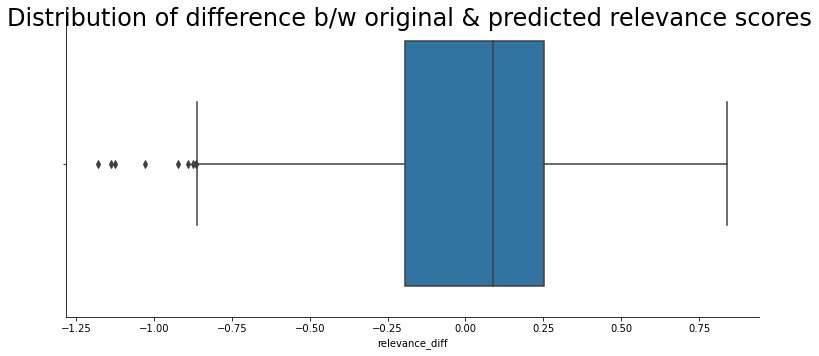

In [ ]:
import seaborn as sns
plot=sns.catplot(x='relevance_diff',kind='box',data=train_new,height=5,aspect=2)
#https://stackoverflow.com/questions/64258570/seaborn-title-error-attributeerror-facetgrid-object-has-no-attribute-set-t
plot.fig.suptitle("Distribution of difference b/w original & predicted relevance scores",
                  fontsize=24, fontdict={"weight": "bold"})